In [31]:
import numpy as np

def ReLu(x, derivative=False):
    if(derivative==False):
        return x*(x > 0)
    else:
        return 1*(x > 0)

def Softmax(x):
    x -= np.max(x)
    sm = (np.exp(x).T / np.sum(np.exp(x),axis=1)).T
    return sm

def CreateWeights():
    ##Initialization of the Weights and the Biases with the random gaussian function with mean zeron, and variance between 1/sqtr(num_inputs_layer)
    
    ninputs = 128
    wl1 = 500 ##Number of neurons in the first layer
    wl2 = 300 ##Number of neurons in the second layer
    nclass = 10 ##Numer of the class, in this case it is the number of the digits.
    
    #layer1
    w1 = np.random.normal(0, ninputs**-0.5, [ninputs,wl1])
    b1 = np.random.normal(0, ninputs**-0.5, [1,wl1])
    
    #Layer2
    w2 = np.random.normal(0, wl1**-0.5, [wl1,wl2])
    b2 = np.random.normal(0, wl1**-0.5, [1,wl2])

    #Layer3
    w3 = np.random.normal(0, wl2**-0.5, [wl2,nclass])
    b3 = np.random.normal(0, wl2**-0.5, [1,nclass])
    
    return [w1,w2,w3,b1,b2,b3]

def Dropout(x, keep_prop):
    mask = np.random.binomial([np.ones_like(x)],(1-keep_prop))[0]  / (1-keep_prop)
    return x*mask

def predict(weights, x, keep_prop=0):
    
    w1,w2,w3,b1,b2,b3  = weights 
    
    #1-Hidden Layer
    first = ReLu(x@w1+b1)
    first = Dropout(first, keep_prop)

    #2-Hidden Layer
    second = ReLu(first@w2+b2)
    second = Dropout(second, keep_prop)
    
    #Output Layer
    return [first, second, Softmax(second@w3+b3)]

def accuracy(output, y):
    hit = 0
    output = np.argmax(output, axis=1)
    y = np.argmax(y, axis=1)
    for y in zip(output, y):
        if(y[0]==y[1]):
            hit += 1

    p = (hit*100)/output.shape[0]
    return p

def log2(x):
    if(x!=0):
        return np.log(x)
    else:
        return -np.inf
    
def log(y):
    return [[log2(nx) for nx in x]for x in y]

def cost(Y_predict, Y_right):
    
    Loss = -np.mean(Y_right*log(Y_predict) + (1-Y_right)*log(1-Y_predict))
    return Loss

def SGD(weights, x, t, outputs, eta, gamma, nabla, cache=None):
    
    w1,w2,w3,b1,b2,b3  = weights
    
    
    if(cache==None):
            vw1 = np.zeros_like(w1)
            vw2 = np.zeros_like(w2)
            vw3 = np.zeros_like(w3)
            vb1 = np.zeros_like(b1)
            vb2 = np.zeros_like(b2)
            vb3 = np.zeros_like(b3)
    else:
        vw1,vw2,vw3,vb1,vb2,vb3 = cache
    
    first, second, y = outputs
   
    w3_delta = (t-y)
    
    w2_error = w3_delta@w3.T

    w2_delta = w2_error * ReLu(second,derivative=True)

    w1_error = w2_delta@w2.T
    w1_delta = w1_error * ReLu(first,derivative=True)
    
    eta = -eta/x.shape[0]
 
    vw3 = gamma*vw3 + eta * (second.T@w3_delta + nabla*w3)
    vb3 = gamma*vb3 + eta * w3_delta.sum(axis=0)

    vw2 = gamma*vw2 + eta * (first.T@w2_delta + nabla*w2)
    vb2 = gamma*vb2 + eta * w2_delta.sum(axis=0)

    vw1 = gamma*vw1 + eta * (x.T@w1_delta + nabla*w1)
    vb1 = gamma*vb1 + eta * w1_delta.sum(axis=0)
    
    
    w3 -= vw3
    b3 -= vb3

    w2 -= vw2
    b2 -= vb2

    w1 -= vw1
    b1 -= vb1
    
    weights = [w1,w2,w3,b1,b2,b3]
    cache = [vw1,vw2,vw3,vb1,vb2,vb3]
    
    return weights, cache

def one_hot_encode(labels, num_classes):
    """
    使用NumPy实现One-Hot编码

    参数：
    labels：标签列表或数组
    num_classes：类别数量

    返回值：
    one_hot：One-Hot编码表示的矩阵，形状为 (N, num_classes)，N为标签数量
    """
    one_hot=np.eye(num_classes)[labels.reshape(-1)].astype(int)

    return one_hot

In [32]:
epochs=20
batch_size=32
lr=1e-3
alpha = 1e-3
decay = 0.1
momentum = 0
l2 = 0.001
cache=None
x_train=np.load('Assignment1-Dataset/train_data.npy')
x_test=np.load('Assignment1-Dataset/test_data.npy')
y_train=np.load('Assignment1-Dataset/train_label.npy')
y_test=np.load('Assignment1-Dataset/test_label.npy')

model=CreateWeights()


train_loss=[]
train_acc=[]
max_train_acc=0
min_train_loss=np.inf
for epoch in range(epochs):
    permutation = np.random.permutation(len(x_train))
    shuffled_X = x_train[permutation, :]
    shuffled_Y = y_train[permutation, :]

    for batch_start in range(0, len(x_train), batch_size):
        batch_end = min(batch_start + batch_size, len(x_train))
        batch_X = shuffled_X[batch_start:batch_end,: ]
        batch_Y = shuffled_Y[batch_start:batch_end, :]
        batch_Y=one_hot_encode(batch_Y,num_classes=10)
        
        pred=predict(weights=model,
                     x=batch_X,
                     keep_prop=0)
        loss=cost(pred[-1],batch_Y)
        acc=accuracy(output=pred[-1],
                     y=batch_Y)
        model, cache = SGD(model, batch_X, batch_Y, pred, alpha, momentum, l2, cache)
        
        # log
        train_loss.append(loss)
        train_acc.append(acc)
        
        if loss<min_train_loss:
            min_train_loss=loss
        if acc>max_train_acc:
            max_train_acc=acc
        
    # weight decay
    alpha = alpha - (alpha*decay)
    print(f'Epoch:{epoch+1}/{epochs}  | Min Loss:{min_train_loss:.4f} | Max Accuracy:{max_train_acc:.2f}%')

Epoch:1/20  | Min Loss:0.2431 | Max Accuracy:59.38%
Epoch:2/20  | Min Loss:0.2294 | Max Accuracy:62.50%
Epoch:3/20  | Min Loss:0.2060 | Max Accuracy:68.75%
Epoch:4/20  | Min Loss:0.2060 | Max Accuracy:68.75%
Epoch:5/20  | Min Loss:0.1979 | Max Accuracy:68.75%
Epoch:6/20  | Min Loss:0.1979 | Max Accuracy:68.75%
Epoch:7/20  | Min Loss:0.1827 | Max Accuracy:71.88%
Epoch:8/20  | Min Loss:0.1827 | Max Accuracy:71.88%
Epoch:9/20  | Min Loss:0.1827 | Max Accuracy:71.88%
Epoch:10/20  | Min Loss:0.1827 | Max Accuracy:71.88%
Epoch:11/20  | Min Loss:0.1754 | Max Accuracy:75.00%
Epoch:12/20  | Min Loss:0.1754 | Max Accuracy:75.00%
Epoch:13/20  | Min Loss:0.1754 | Max Accuracy:75.00%
Epoch:14/20  | Min Loss:0.1754 | Max Accuracy:75.00%
Epoch:15/20  | Min Loss:0.1754 | Max Accuracy:75.00%
Epoch:16/20  | Min Loss:0.1754 | Max Accuracy:75.00%
Epoch:17/20  | Min Loss:0.1743 | Max Accuracy:75.00%
Epoch:18/20  | Min Loss:0.1697 | Max Accuracy:78.12%
Epoch:19/20  | Min Loss:0.1697 | Max Accuracy:78.12%
Ep

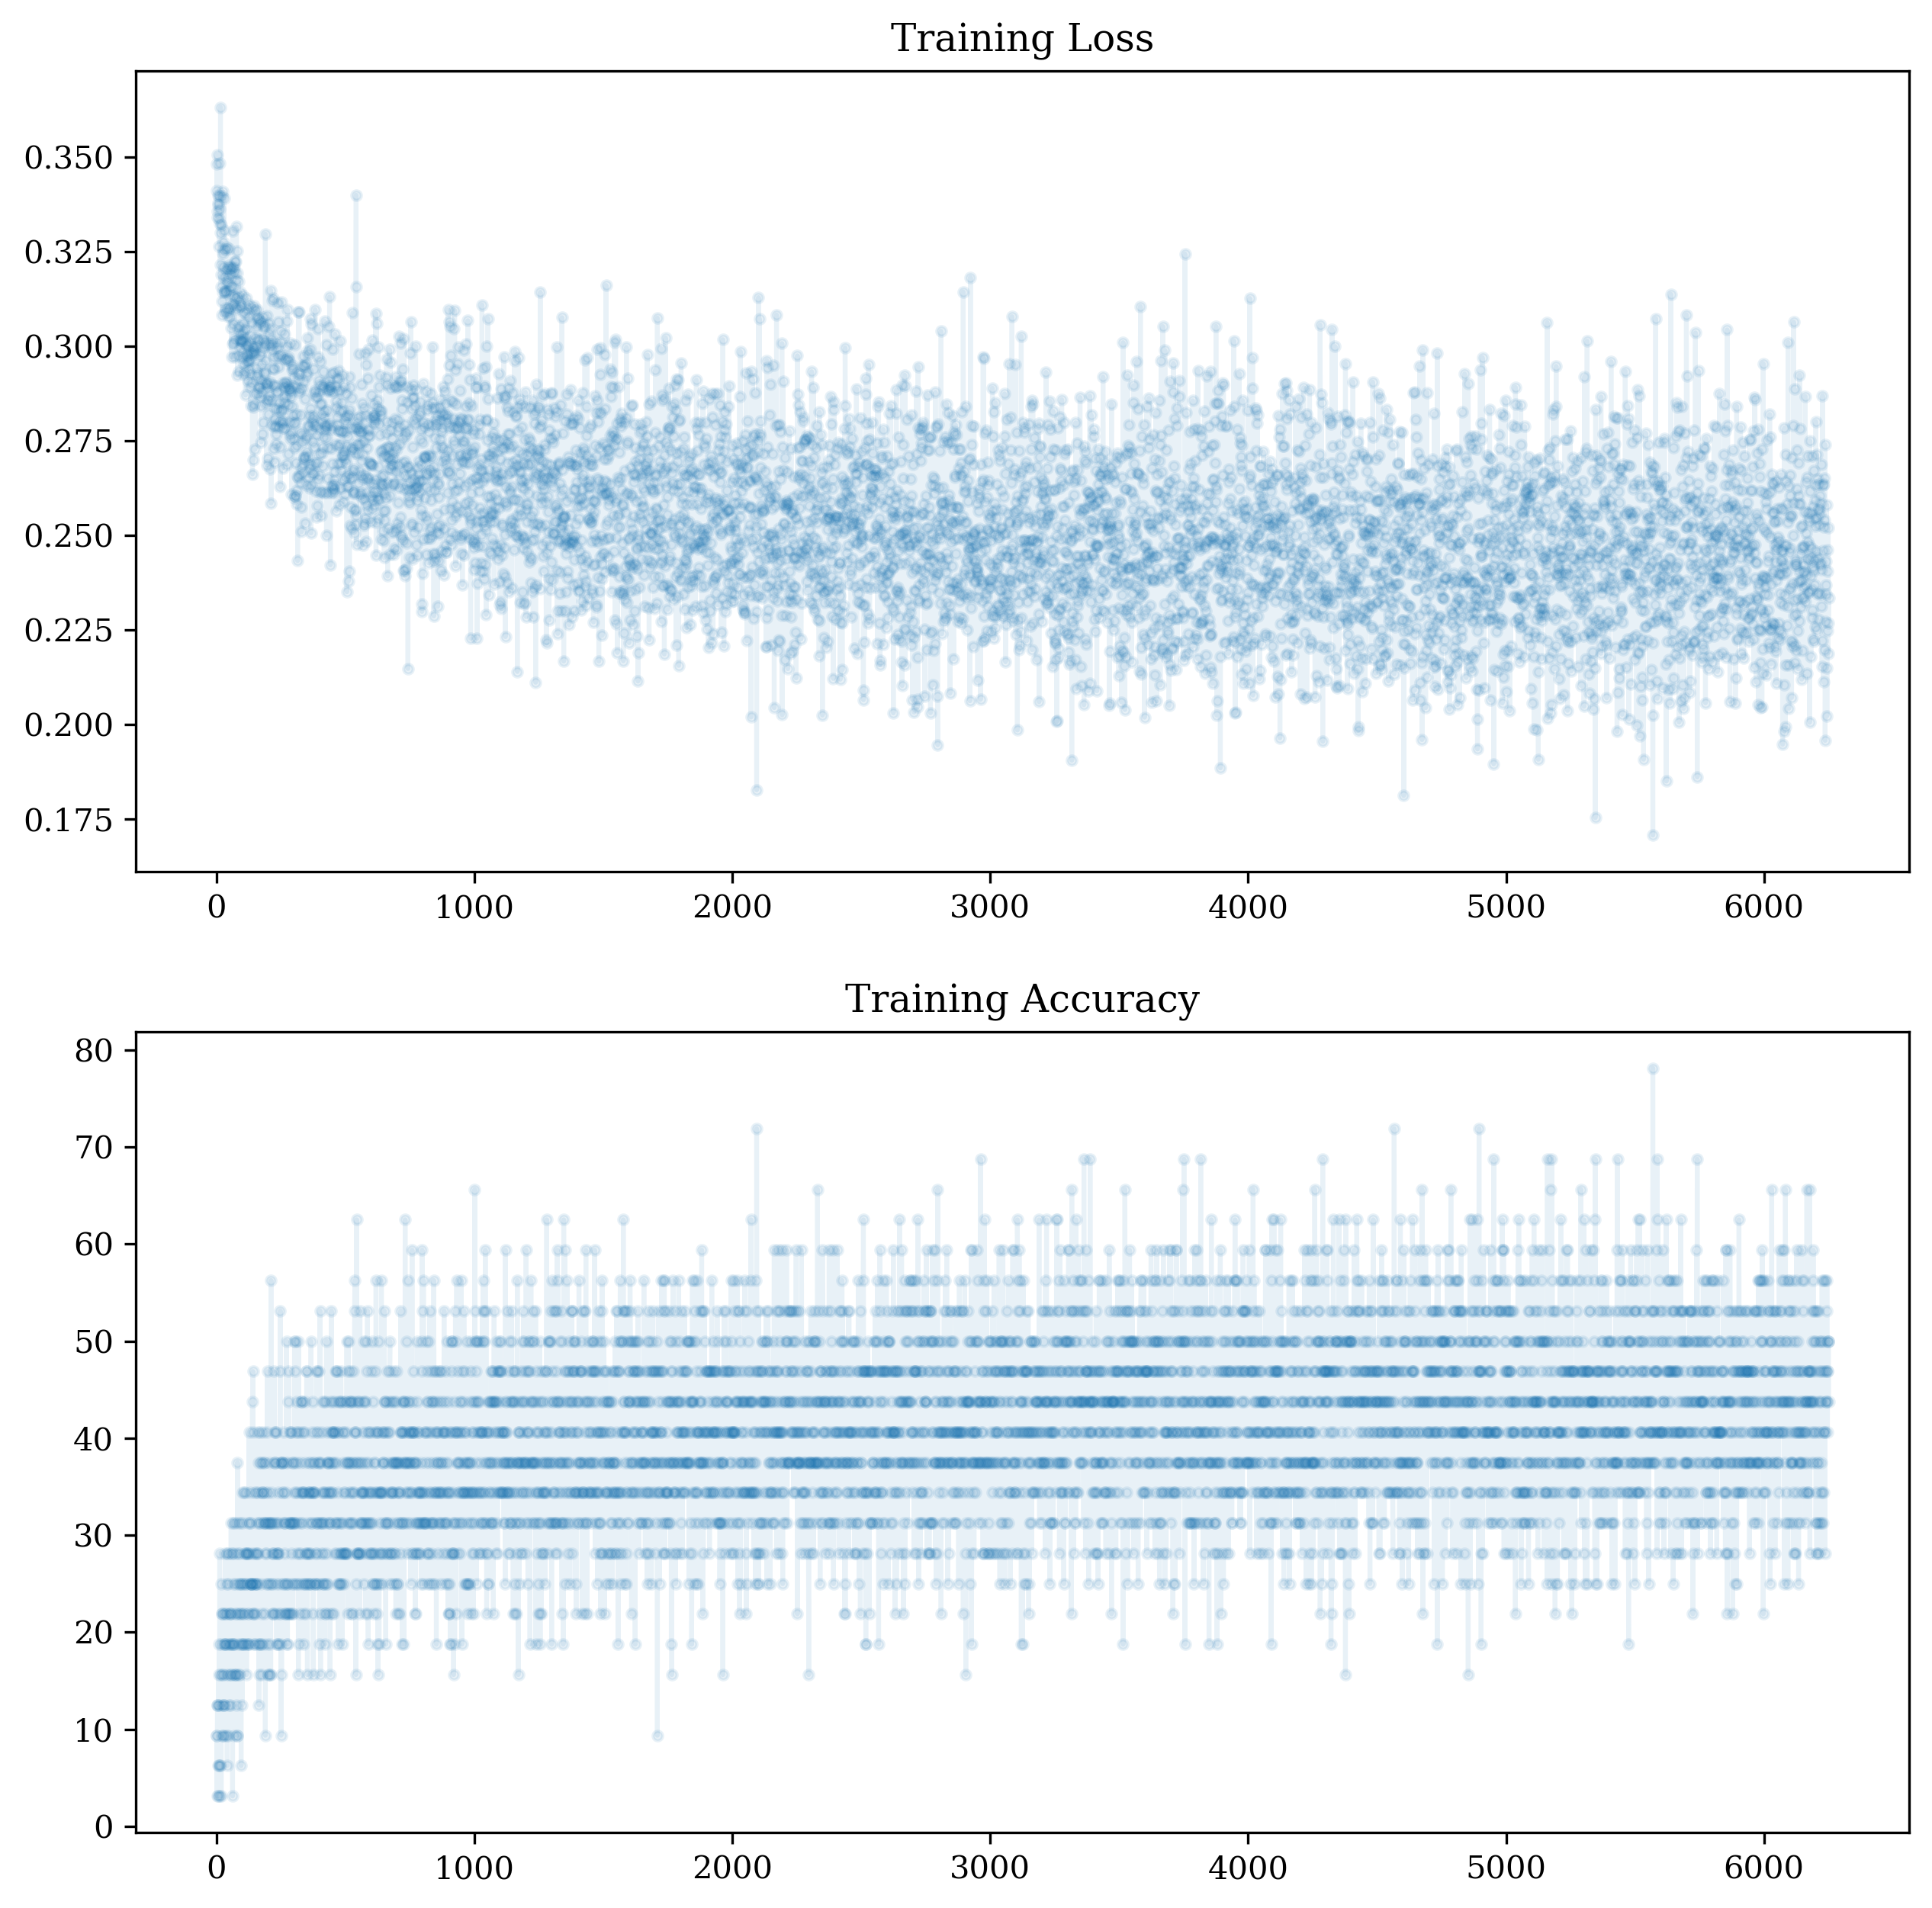

In [36]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'

plt.figure(figsize=(10,10),dpi=300)

plt.subplot(211)
plt.title('Training Loss')
plt.plot(train_loss[::5],alpha=0.1,marker='.')
plt.subplot(212)
plt.title('Training Accuracy')
plt.plot(train_acc[::5],alpha=0.1,marker='.')
plt.savefig('log.jpg')